# Atividade 6

Aluno: Raul Procópio Mota

Matrícula: 102100648

# Entrada de dados

Lê e processa os dados do deck do Newave

In [160]:
import os
from PySDDP.Pen import Newave

Caminho_do_Arquivo = os.getcwd() + '/NewaveAgo2023/'

PMO = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# Modelagem do problema

$$Min \hspace{0.5cm} \sum_{ano=1931}^{2021}\varepsilon_{ago,ano}^2$$

Sujeito a:

$$Z_{ago,1931} = \phi_1 \cdot Z_{jul,1931} + \phi_2 \cdot Z_{jun,1931} + ... +  \phi_n \cdot Z_{n,1931}  + \varepsilon_{ago,1931}^2  $$

$$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{ago,1932}^2  $$

$$.$$

$$.$$

$$.$$

$$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{ago,2021}^2  $$

$$\sum_{ano=1931}^{2021}\varepsilon_{ago,ano} = 0 $$

In [161]:
import numpy as np
from cvxopt import solvers, matrix

def otimiza_modelo(nome_usina):

    phi_modelo_otimo = []
    matriz_residuos = []

    for mes in range(12):
        phi_mes = np.inf
        residuos_mes = np.inf

        for ordem in np.arange(1,12,1):
            phi, residuos = otimiza_coeficientes(nome_usina, ordem, mes)

            if (np.sum(np.power(residuos, 2)) < np.sum(np.power(residuos_mes, 2))):
                phi_mes = phi
                residuos_mes = residuos

        phi_modelo_otimo.append(phi_mes)
        matriz_residuos.append(residuos_mes)

    return phi_modelo_otimo, matriz_residuos

def otimiza_coeficientes(nome_usina, ordem, mes):

    # Obtem os dados da usina
    usina = PMO.confhd.get(nome_usina)

    # Valida a usina
    if usina is None:
        raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')
    
    # Valida a ordem
    if not(1 <= ordem <= 11):
        raise Exception('A ordem do modelo deve estar entre 1 e 11 meses.')
    
    # Valida o mes
    if not(0 <= mes <= 11):
        raise Exception('O mês selecionado deve estar entre 0 e 11 (Jan-Dez)')

    # Obtem as vazões naturais afluentes da usina retirando os dois últimos anos
    VNA = usina['vazoes'][:-2]

    # Cria os parâmetros que compõe o problma quadrático
    P = matrix(cria_matriz_quadratica_fob(VNA, ordem, mes).astype('float'))
    q = matrix(cria_vetor_linear_fob(VNA, ordem, mes).astype('float'))
    G = matrix(cria_matriz_coef_restricoes_desigualdade(VNA, ordem, mes).astype('float'))
    h = matrix(cria_vetor_valores_restricoes_desigualdade(VNA, ordem, mes).astype('float'))
    A = matrix(cria_matriz_coef_restricoes_igualdade(VNA, ordem, mes).astype('float'))
    b = matrix(cria_vetor_valores_restricoes_igualdade(VNA, ordem, mes).astype('float'))

    # Realiza o tratamento de parâmetros vazios
    if not(len(P)): P = None
    if not(len(q)): q = None
    if not(len(G)): G = None
    if not(len(h)): h = None
    if not(len(A)): A = None
    if not(len(b)): b = None

    # Define as tolerâncias de convergência
    abstol = 1e-9
    reltol = 1e-9

    # Soluciona o problema quadrático
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b, solver='glpk', abstol=abstol, reltol=reltol)
   
    phi = sol['x'][:ordem]
    residuos = sol['x'][ordem:]

    return phi, residuos

def cria_matriz_quadratica_fob(VNA, ordem, mes):
    # Obtem o número de anos e número de meses presentes na VNA
    num_ano, num_mes = np.shape(VNA)

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    # if (mes < ordem):
    num_ano -= 1

    # Criar a matriz diagonal que representa a matriz quadrática da fob
    matriz = np.diag(np.concatenate((0.0000000001*np.ones(ordem), 2*np.ones(num_ano)), axis=0))

    return matriz

def cria_vetor_linear_fob(VNA, ordem, mes):
    # Obtem o número de anos e número de meses presentes na VNA
    num_ano, num_mes = np.shape(VNA)

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    # if (mes < ordem):
    num_ano -= 1

    # Criar a vetor que representa os custos lineares da fob
    vetor = np.zeros(ordem + num_ano)

    return vetor

def cria_matriz_coef_restricoes_desigualdade(VNA, ordem, mes):
    # Não existem restrições de desigualdade
    matriz = np.array([])

    # Obtem o número de anos e número de meses presentes na VNA
    num_ano, num_mes = np.shape(VNA)

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    # if (mes < ordem):
    num_ano -= 1

    matriz = np.vstack((-1*np.eye(ordem+num_ano), np.eye(ordem+num_ano)))

    return matriz

def cria_vetor_valores_restricoes_desigualdade(VNA, ordem, mes):
    # Não existem restrições de desigualdade
    vetor = np.array([])

    # Obtem o número de anos e número de meses presentes na VNA
    num_ano, num_mes = np.shape(VNA)

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    # if (mes < ordem):
    num_ano -= 1

    vetor = 99999*np.ones((ordem+num_ano)*2)

    return vetor

def cria_matriz_coef_restricoes_igualdade(VNA, ordem, mes):
    
    # Transforma a matriz de vazões em um vetor
    VNA_achatada = VNA.flatten()
    
    # Divide a matriz achatada de forma que o primeiro valor seja referente ao mês de interesse 
    # e o último valor seja referente ao mês anterior ao de interesse
    primeira_linha, matriz_achatada, ultima_linha = np.split(VNA_achatada, [mes, mes-12])
    
    # Caso o mês seja maior ou igual à ordem do modelo, os dados da primeira linha são incorporados 
    # à matriz de coeficientes achatada 
    # if (mes >= ordem):
    #     # Primeira linha completada com zeros à esquerda (total de itens = 12)
    #     primeira_linha = np.concatenate((np.zeros(12-mes), primeira_linha))

    #     # Junção da primeira linha à matriz de coeficientes achatada
    #     matriz_achatada = np.concatenate((primeira_linha, matriz_achatada), axis=0)

    # Define o formato da matriz de conficientes de restrições de igualdade reconfigurada (dimensão num_ano x num_mes)
    num_mes = 12
    num_anos = np.size(matriz_achatada)//num_mes

    # Cria a matriz apenas com os meses necessários para o modelo
    matriz = np.reshape(matriz_achatada, (num_anos, num_mes))[:,-ordem:]

    # Concatena à matriz os erros de cada equação representados pela matrix identidade
    matriz = np.concatenate((matriz, np.eye(num_anos)), axis=1)

    # Adiciona a condição de que a media dos residuos deve ser nulo
    matriz = np.concatenate((matriz, np.concatenate((np.zeros((1,ordem)), np.ones((1,num_anos))), axis=1)), axis=0)

    return matriz

def cria_vetor_valores_restricoes_igualdade(VNA, ordem, mes):
    # Define a linha inicial da aquisição de dados
    num_primeira_linha = 0

    # Caso o mês seja menor que a ordem do modelo, o dados do primeiro ano do histórico serão ignorados
    # if (mes < ordem):
    num_primeira_linha += 1

    # # Criar a vetor que representa os valores das equações de igualdade 
    vetor = VNA[num_primeira_linha:, mes]

    # Adiciona a condição de que a media dos residuos deve ser nulo
    vetor = np.concatenate((vetor, np.array([0])), axis=0)
        
    return vetor

## Funções de criação de dados

In [162]:
import numpy as np
import random

def calcula_vazao(nome_usina, ordem, mes, ano, phi):

    # Obtem os dados da usina
    usina = PMO.confhd.get(nome_usina)

    # Valida a usina
    if usina is None:
        raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')
    
    # Valida a usina
    if ordem != len(phi):
        raise Exception('O número de coeficientes do modelo de regressão é diferente da ordem.')
    
    # Vazão natural afluente
    VNA = usina['vazoes'][:-2]

    num_anos, num_mes = np.shape(VNA)
    
    if (ano-1931 >= num_anos) or (ano < 1931):
        raise Exception('O ano selecionado não possui histórico que possibilite a estimação da vazão (Min: 1931, Max: ' + str(1931+num_anos-1) + ').')

    vazao_real = VNA[ano-1931, mes]

    if (mes < ordem):
        if (ano < 1932):
            raise Exception('Não existem dados para estimar a vazão na data ' + str(mes+1) + '/' + str(ano) + '.')
        else:
            vazao_estimada = np.dot(VNA[ano-1932, mes-ordem:], phi[:ordem-mes])
            vazao_estimada += np.dot(VNA[ano-1931, :mes], phi[ordem-mes:])
    else:
        vazao_estimada = np.dot(VNA[ano-1931, mes-ordem:mes], phi)
        
    vazao_estimada = vazao_estimada
    erro = vazao_real - vazao_estimada

    return {
        'vazao_real': vazao_real,
        'vazao_estimada': vazao_estimada,
        'erro': erro
    }

def cria_serie_sintetica(nome_usina, phi, matriz_residuos, num_series, ano_ini=None, mes_ini=0):
    # Obtem os dados da usina
    usina = PMO.confhd.get(nome_usina)

    # Valida a usina
    if usina is None:
        raise Exception('Usina não encontrada. Por favor, verifique o nome da mesma.')
    
    # Vazão natural afluente
    VNA = usina['vazoes']

    num_anos, num_mes = np.shape(VNA)

    # Valida a data de início
    if ano_ini is None:
        ano_ini = num_anos - 1
    elif (ano_ini < 1932) or (ano_ini > 1931 + num_anos - 1):
        raise Exception('O ano inicial deve estar entre 1932 e ' + str(1931 + num_anos - 1) + '.')
    else:
        ano_ini -= 1931

    if (mes_ini < 0) or (mes_ini > 11):
        raise Exception('O mes inicial deve estar entre 0 e 1.')
    

    ordem = [len(phi_i) for phi_i in phi]

    series_sinteticas = []

    for i_serie in range(num_series):
        if i_serie == 0:
            vazoes_base = VNA[ano_ini-1]
        else:
            vazoes_base = series_sinteticas[-1]
        
        serie_atual = []
        for mes in range(12):
            if (i_serie == 0) and (mes < mes_ini):
                vazao_mensal = VNA[ano_ini][mes]
            else:
                vazao_mensal = 0

                if mes - ordem[mes] < 0:
                    for k, v in enumerate(vazoes_base[mes - ordem[mes]:]):
                        vazao_mensal += phi[mes][k]*v

                    for k, v in enumerate(serie_atual[0:mes]):
                        vazao_mensal += phi[mes][k + ordem[mes] - mes]*v

                else:
                    for k, v in enumerate(serie_atual[(mes-ordem[mes]):mes]):
                        vazao_mensal += phi[mes][k]*v

                vazao_mensal += random.choice(matriz_residuos[mes])

            serie_atual.append(vazao_mensal)

        series_sinteticas.append(serie_atual)

    return series_sinteticas

## Programa principal

In [184]:
# Nome_Usina = 'I. SOLTEIRA'
Nome_Usina = 'MONTE CLARO'

In [191]:
import numpy as np

Ano_Inicial = 1989
Mes_inicial = 0
Numero_Series = 1
Numero_Repeticoes = 2000

phi, matriz_residuos = otimiza_modelo(Nome_Usina)

series_sinteticas = cria_serie_sintetica(Nome_Usina, phi, matriz_residuos, Numero_Series, Ano_Inicial, Mes_inicial)

for i in range(Numero_Repeticoes):
    series_sinteticas = np.vstack((series_sinteticas, cria_serie_sintetica(Nome_Usina, phi, matriz_residuos, Numero_Series, Ano_Inicial, Mes_inicial)))


In [192]:
import numpy as np

# Previsão para os próximos 5 anos
Ano_Inicial_Previsao = 2023
Mes_inicial_Previsao = 7
Numero_Series_Previsao = 5
Numero_Repeticoes_Previsao = 2000

previsao = cria_serie_sintetica(Nome_Usina, phi, matriz_residuos, Numero_Series_Previsao, Ano_Inicial_Previsao, Mes_inicial_Previsao)

for i in range(Numero_Repeticoes_Previsao):
    previsao = np.vstack((previsao, cria_serie_sintetica(Nome_Usina, phi, matriz_residuos, Numero_Series_Previsao, Ano_Inicial_Previsao, Mes_inicial_Previsao)))
    

## Plota gráfico das vazões reais

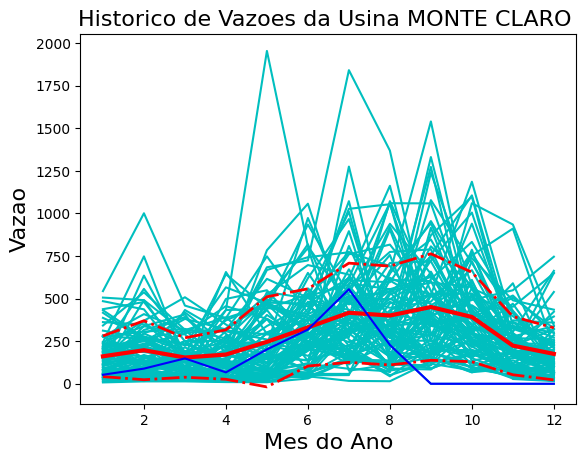

In [193]:
usina = PMO.confhd.get(Nome_Usina)

PMO.confhd.plot_vaz(usina)

## Plota gráfico das séries sintéticas

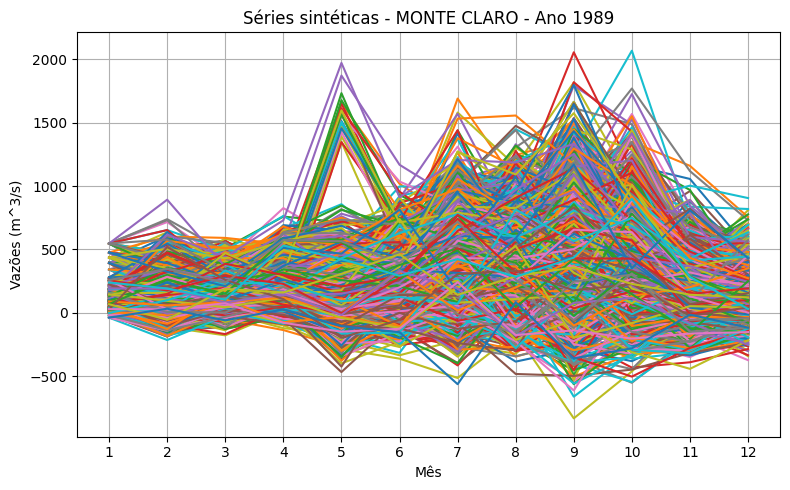

In [194]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

mes_plot = np.arange(1,13,1)

for serie in series_sinteticas:
    plt.plot(mes_plot, serie)

# plt.plot(mes_plot, VNA[Ano_Inicial-1931], label="Ano Analisado")

plt.title('Séries sintéticas - ' + Nome_Usina + ' - Ano ' + str(Ano_Inicial))
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/s)')

# plt.legend()

plt.xticks(mes_plot)
plt.grid()
plt.tight_layout()
plt.show()

## Plota gráfico de médias das séries

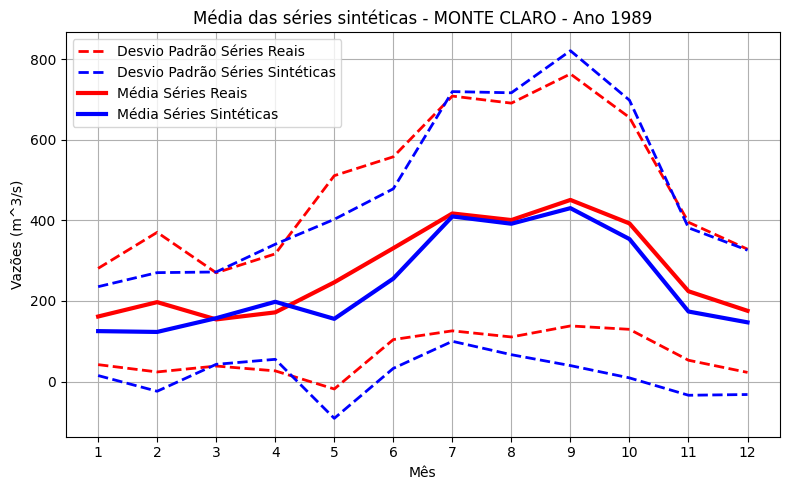

In [195]:
import numpy as np
import matplotlib.pyplot as plt

VNA = usina['vazoes']

plt.figure(figsize=(8,5))

mes_plot = np.arange(1,13,1)

media_reais = np.mean(VNA, axis=0)
media_sinteticas = np.mean(series_sinteticas, axis=0)

desvio_padrao_reais = np.std(VNA, axis=0)
desvido_padrao_sinteticas = np.std(series_sinteticas, axis=0)


# plt.plot(mes_plot, media_reais, '-r', linewidth="3", label="Média Séries Reais")
plt.plot(mes_plot, media_reais+desvio_padrao_reais, '--r', linewidth="2", label="Desvio Padrão Séries Reais")
plt.plot(mes_plot, media_reais-desvio_padrao_reais, '--r', linewidth="2",)

# plt.plot(mes_plot, media_sinteticas,'-b', linewidth="3", label="Média Séries Sintéticas")
plt.plot(mes_plot, media_sinteticas+desvido_padrao_sinteticas, '--b', linewidth="2", label="Desvio Padrão Séries Sintéticas")
plt.plot(mes_plot, media_sinteticas-desvido_padrao_sinteticas, '--b', linewidth="2")

plt.plot(mes_plot, media_reais, '-r', linewidth="3", label="Média Séries Reais")

plt.plot(mes_plot, media_sinteticas,'-b', linewidth="3", label="Média Séries Sintéticas")

# plt.plot(mes_plot, VNA[Ano_Inicial-1931], label="Ano Analisado")

plt.title('Média das séries sintéticas - ' + Nome_Usina + ' - Ano ' + str(Ano_Inicial))
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/s)')

plt.legend()

plt.xticks(mes_plot)
plt.grid()
plt.tight_layout()
plt.show()

## Plota gráfico de previsão dos próximos 5 anos

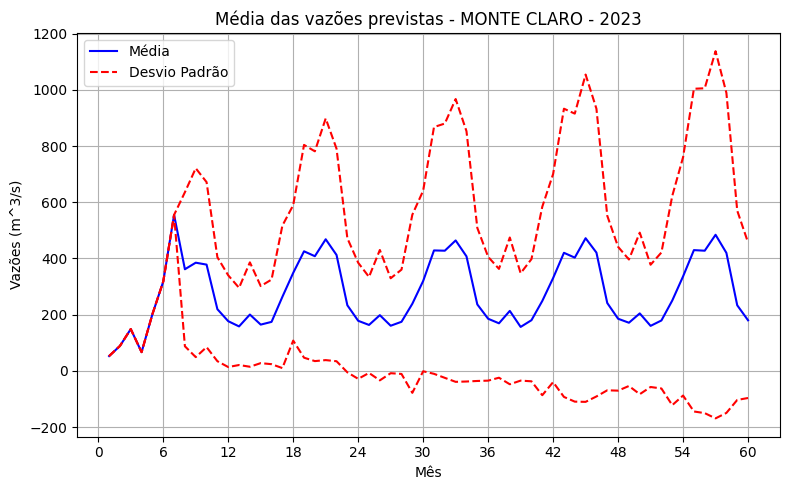

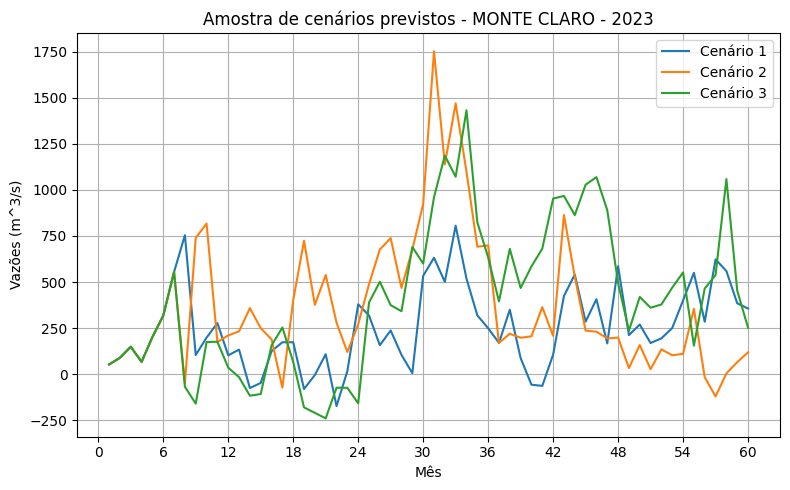

In [221]:
import numpy as np
import matplotlib.pyplot as plt

num_amostra = 3

previsao_ano = [[],[],[],[],[]]
media_previsao_ano = [[],[],[],[],[]]
desvio_padrao_previsao_ano = [[],[],[],[],[]]

for i,serie in enumerate(previsao):
    previsao_ano[i%5].append(serie)

media_previsao_total = []
desvio_padrao_previsao_total = []
amostra_total = []

for i in range(num_amostra):
    amostra_total.append([])

for ano,series in enumerate(previsao_ano):
    media_previsao_total = np.hstack((media_previsao_total, np.mean(series, axis=0)))
    desvio_padrao_previsao_total = np.hstack((desvio_padrao_previsao_total, np.std(series, axis=0)))

    for i,amostra in enumerate(amostra_total):
        amostra_total[i] = np.hstack((amostra_total[i], random.choice(series)))

mes_previsao_plot = np.arange(1,61,1)





plt.figure(figsize=(8,5))

plt.plot(mes_previsao_plot, media_previsao_total, '-b',label='Média')
plt.plot(mes_previsao_plot, media_previsao_total+desvio_padrao_previsao_total, '--r', label='Desvio Padrão')
plt.plot(mes_previsao_plot, media_previsao_total-desvio_padrao_previsao_total, '--r')

plt.title('Média das vazões previstas - ' + Nome_Usina + ' - ' + str(Ano_Inicial_Previsao))
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/s)')

plt.legend()

plt.xticks(np.arange(0,60+1,6))
plt.grid()
plt.tight_layout()
plt.show()




plt.figure(figsize=(8,5))

for i,amostra in enumerate(amostra_total):
    plt.plot(mes_previsao_plot, amostra,label='Cenário ' + str(i+1))

plt.title('Amostra de cenários previstos - ' + Nome_Usina + ' - ' + str(Ano_Inicial_Previsao))
plt.xlabel('Mês')
plt.ylabel('Vazões (m^3/s)')

plt.legend()

plt.xticks(np.arange(0,60+1,6))
plt.grid()
plt.tight_layout()
plt.show()

